# Model fitting 4: Only Synchrotron

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
import jetset
from jetset.test_data_helper import  test_SEDs
from jetset.data_loader import ObsData,Data
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs


In [2]:
print(jetset.__version__)

1.3.0rc9


In [3]:
test_SEDs

['/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_3C345.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_ABS.ecsv',
 '/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk501_EBL_DEABS.ecsv']

## Loading data



In [4]:
print(test_SEDs[1])
data=Data.from_file(test_SEDs[1])


/Users/orion/miniforge3/envs/jetset/lib/python3.10/site-packages/jetset/test_data/SEDs_data/SED_MW_Mrk421_EBL_DEABS.ecsv



***  binning data  ***
---> N bins= 89
---> bin_widht= 0.2



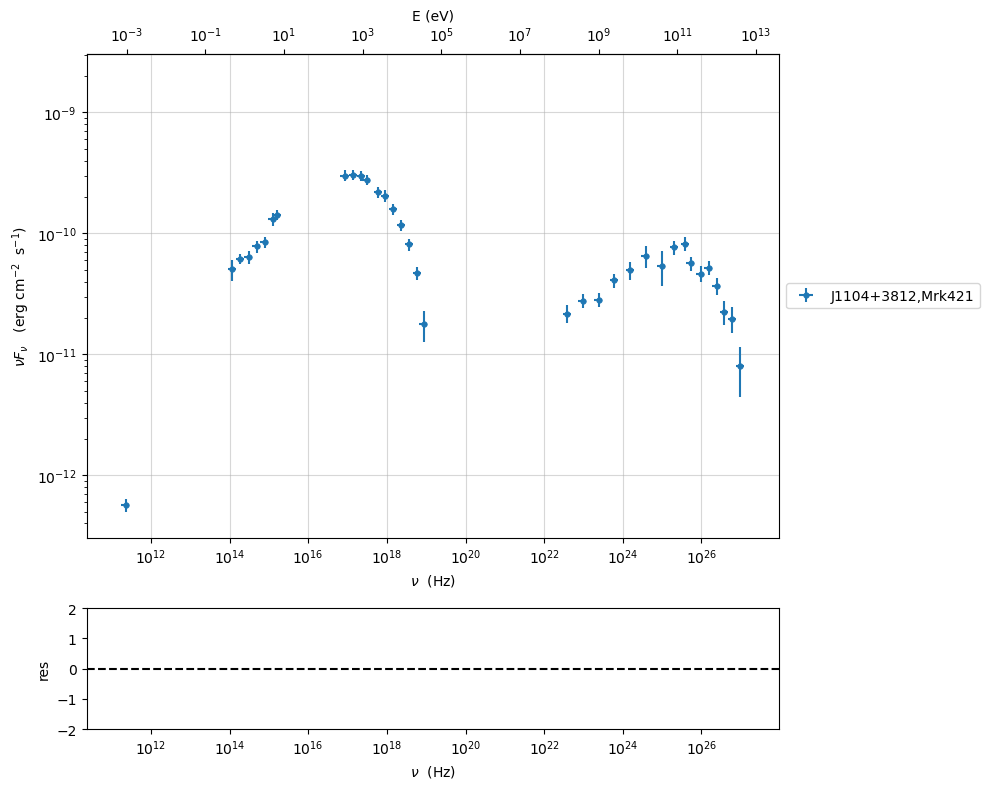

In [5]:
%matplotlib inline
sed_data=ObsData(data_table=data)
sed_data.group_data(bin_width=0.2)

sed_data.add_systematics(0.1,[10.**6,10.**29])
p=sed_data.plot_sed()

In [6]:
sed_data.save('Mrk_401.pkl')

## Phenomenological model constraining

### Spectral indices


*** evaluating spectral indices for data ***



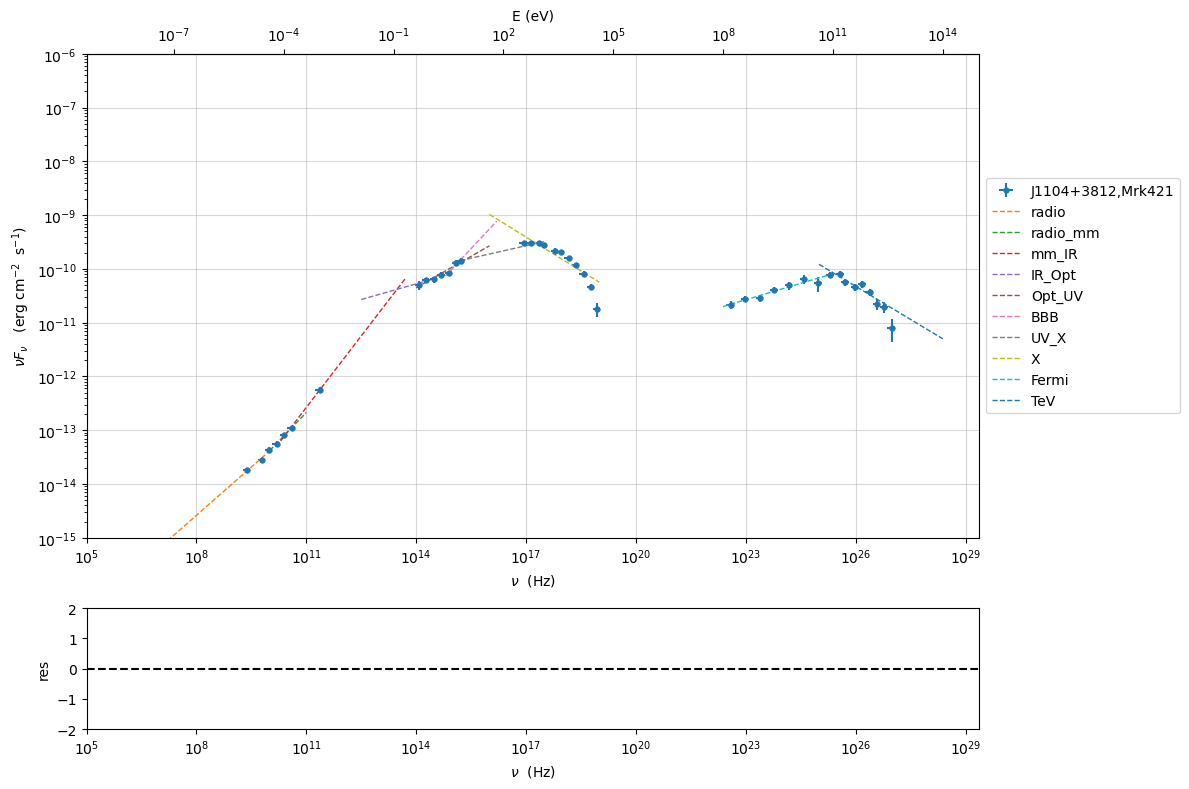

In [7]:
from jetset.sed_shaper import  SEDShape
my_shape=SEDShape(sed_data)
my_shape.eval_indices(silent=True)
p=my_shape.plot_indices()
p.setlim(y_min=1E-15,y_max=1E-6)

### Sed shaper

In [8]:
mm,best_fit=my_shape.sync_fit(check_host_gal_template=False,
                  Ep_start=None,
                  minimizer='lsb',
                  silent=True,
                  fit_range=[10., 21.])


*** Log-Polynomial fitting of the synchrotron component ***
---> first blind fit run,  fit range: [10.0, 21.0]
---> class:  HSP





model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.585748e-01,-1.585748e-01,6.470535e-03,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-1.089513e-02,-1.089513e-02,9.764985e-04,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,1.673177e+01,1.673177e+01,2.478677e-02,--,1.667298e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-9.489417e+00,-9.489417e+00,1.853260e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> sync       nu_p=+1.673177e+01 (err=+2.478677e-02)  nuFnu_p=-9.489417e+00 (err=+1.853260e-02) curv.=-1.585748e-01 (err=+6.470535e-03)




*** Log-Polynomial fitting of the IC component ***
---> fit range: [23.0, 29.0]
---> LogCubic fit
====> simplex
====> migrad
====> simplex
====> migrad
====> simplex
====> migrad




model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
LogCubic,b,-1.971111e-01,-1.971111e-01,2.679732e-02,--,-1.000000e+00,-1.000000e+01,0.000000e+00,False
LogCubic,c,-4.037544e-02,-4.037544e-02,2.119803e-02,--,-1.000000e+00,-1.000000e+01,1.000000e+01,False
LogCubic,Ep,2.521789e+01,2.521789e+01,1.198160e-01,--,2.529262e+01,0.000000e+00,3.000000e+01,False
LogCubic,Sp,-1.012535e+01,-1.012535e+01,2.996508e-02,--,-1.000000e+01,-3.000000e+01,0.000000e+00,False


---> IC         nu_p=+2.521789e+01 (err=+1.198160e-01)  nuFnu_p=-1.012535e+01 (err=+2.996508e-02) curv.=-1.971111e-01 (err=+2.679732e-02)



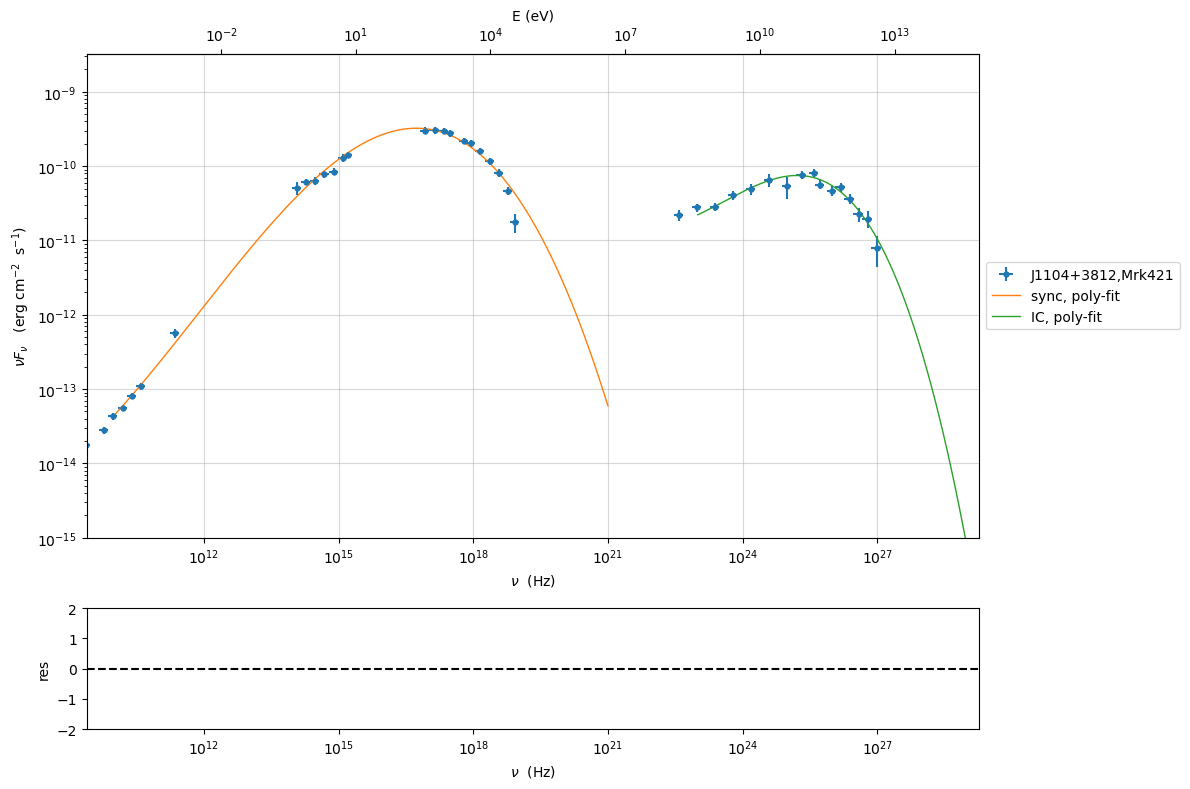

In [9]:
my_shape.IC_fit(fit_range=[23., 29.],minimizer='minuit',silent=True)
p=my_shape.plot_shape_fit()
p.setlim(y_min=1E-15)

### Model constraining

In [10]:
from jetset.obs_constrain import ObsConstrain
from jetset.model_manager import  FitModel
from jetset.minimizer import fit_SED
sed_obspar=ObsConstrain(beaming=25,
                        B_range=[0.001,0.1],
                        distr_e='lppl',
                        t_var_sec=3*86400,
                        nu_cut_IR=1E12,
                        SEDShape=my_shape)


prefit_jet=sed_obspar.constrain_SSC_model(electron_distribution_log_values=False,silent=True)
prefit_jet.save_model('prefit_jet.pkl')


***  constrains parameters from observable ***

===> setting C threads to 12


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,R,region_size,cm,3.460321e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True
jet_leptonic,beam_obj,beaming,,2.500000e+01,1.000000e-04,--,False,False
jet_leptonic,z_cosm,redshift,,3.080000e-02,0.000000e+00,--,False,False
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,6.545152e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.333017e+04,1.000000e+00,1.000000e+09,False,False


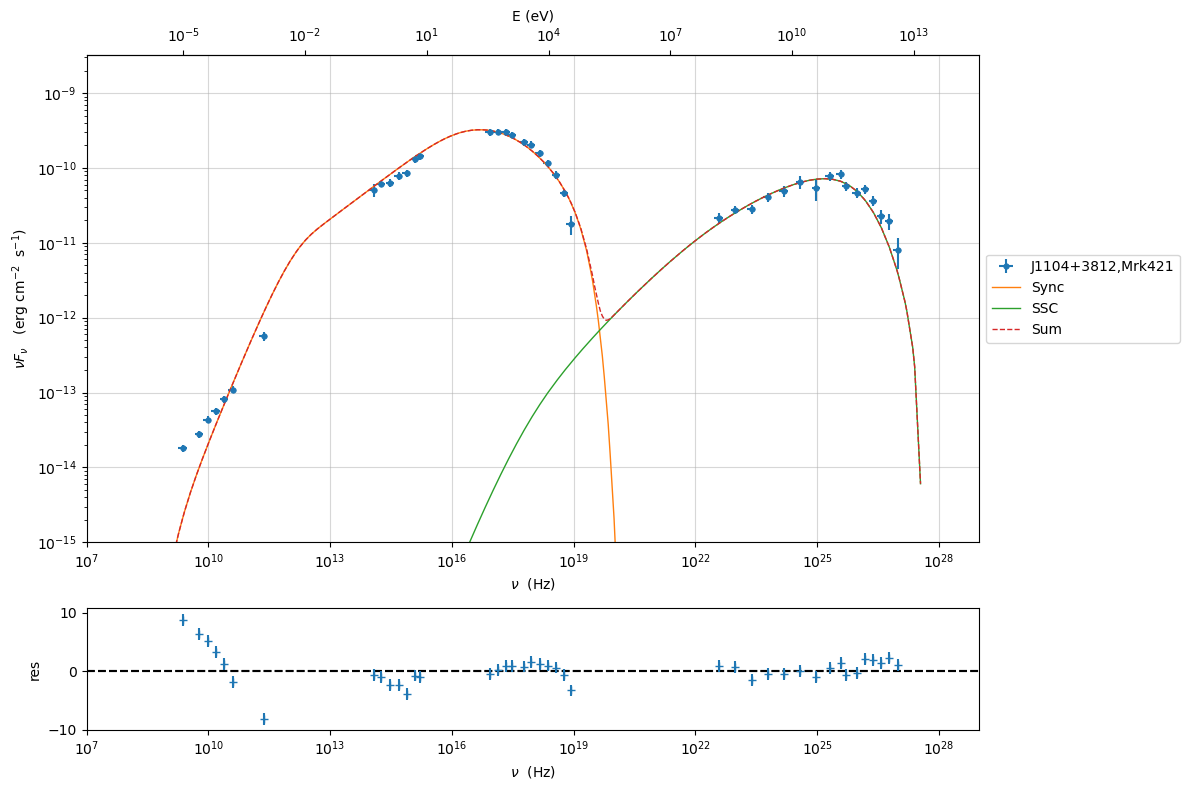

In [11]:
pl=prefit_jet.plot_model(sed_data=sed_data)
pl.add_residual_plot(prefit_jet,sed_data)
pl.setlim(y_min=1E-15,x_min=1E7,x_max=1E29)

## Model fitting only Synchorotron component

### Model fitting with Minuit

In [12]:
from jetset.jet_model import Jet
jet_minuit=Jet.load_model('prefit_jet.pkl')
jet_minuit.set_gamma_grid_size(200)

===> setting C threads to 12


we switch off the IC component

In [13]:

jet_minuit.spectral_components.SSC.state='off'
jet_minuit.show_model()


--------------------------------------------------------------------------------
model description: 
--------------------------------------------------------------------------------
type: Jet
name: jet_leptonic  
geometry: spherical  

electrons distribution:
 type: lppl  
 gamma energy grid size:  201
 gmin grid : 4.697542e+02
 gmax grid : 1.373160e+06
 normalization:  True
 log-values:  False
 ratio of cold protons to relativistic electrons: 1.000000e+00

radiative fields:
 seed photons grid size:  100
 IC emission grid size:  100
 source emissivity lower bound :  1.000000e-120
 spectral components:
   name:Sum, state: on
   name:Sum, hidden: False
   name:Sync, state: self-abs
   name:Sync, hidden: False
   name:SSC, state: off
   name:SSC, hidden: False
external fields transformation method: blob

SED info:
 nu grid size jetkernel: 1000
 nu size: 500
 nu mix (Hz): 1.000000e+06
 nu max (Hz): 1.000000e+30

flux plot lower bound   :  1.000000e-30

------------------------------------

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.697542e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,6.545152e-01,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.333017e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.183468e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,7.928739e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.460321e+16,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,5.050000e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True


--------------------------------------------------------------------------------


In [14]:
fit_model_minuit=FitModel( jet=jet_minuit, name='Only-Synch-best-fit-minuit') 

fit_model_minuit.freeze('jet_leptonic','z_cosm')
fit_model_minuit.freeze('jet_leptonic','R_H')
fit_model_minuit.freeze('jet_leptonic','R')
fit_model_minuit.freeze('jet_leptonic','gmax')
fit_model_minuit.jet_leptonic.parameters.R.fit_range=[10**15.5, 10**17.5]
fit_model_minuit.jet_leptonic.parameters.beam_obj.fit_range=[5., 50.]

In [15]:
from jetset.minimizer import fit_SED,ModelMinimizer

model_minimizer_minuit=ModelMinimizer('minuit')
best_fit_minuit=model_minimizer_minuit.fit(fit_model_minuit,sed_data,10.0**15,10**20.0,fitname='SSC-best-fit-minuit',repeat=3)

filtering data in fit range = [1.000000e+15,1.000000e+20]
data length 13

*** start fit process ***
----- 
fit run: 0


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=1.66861e+00

fit run: 1
- old chisq=1.66861e+00


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=1.66861e+00

fit run: 2
- old chisq=1.66861e+00


0it [00:00, ?it/s]

====> simplex
====> migrad
- best chisq=1.66860e+00

-------------------------------------------------------------------------
Fit report

Model: SSC-best-fit-minuit


model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,4.226997e+02,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,1.373160e+06,1.000000e+00,1.000000e+15,False,True
jet_leptonic,N,emitters_density,1 / cm3,1.083644e+00,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,4.047533e+04,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,2.121360e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,6.256219e-01,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,3.460321e+16,1.000000e+03,1.000000e+30,False,True
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,1.422387e-02,0.000000e+00,--,False,False
jet_leptonic,NH_cold_to_rel_e,cold_p_to_rel_e_ratio,,1.000000e+00,0.000000e+00,--,False,True



converged=True
calls=165
mesg=


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.669                      │              Nfcn = 165              │
│ EDM = 3.3e-05 (Goal: 0.0002)     │            time = 3.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_0 │  0.42e3   │  0.11e3   │            │            │    1    │  1e+09  │       │
│ 1 │ par_1 │   1.08    │   0.30    │            │            │    0    │         │       │
│ 2 │ par_2 │   40e3    │    7e3    │            │            │    1    │  1e+09  │       │
│ 3 │ par_3 │   2.12    │   0.05    │            │            │   -10   │   10    │       │
│ 4 │ par_4 │   0.63    │   0.07    │            │            │   -15   │   15    │       │
│ 5 │ par_5 │  0.0142   │  0.0014   │            │            │    0    │         │       │
│ 6 │ par_6 │   36.3    │    2.4    │            │            │    5    │   50    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

dof=6
chisq=1.668605, chisq/red=0.278101 null hypothesis sig=0.947519

best fit pars


model name,name,val,bestfit val,err +,err -,start val,fit range min,fit range max,frozen
jet_leptonic,gmin,4.226997e+02,4.226997e+02,1.139513e+02,--,4.697542e+02,1.000000e+00,1.000000e+09,False
jet_leptonic,gmax,1.373160e+06,--,--,--,1.373160e+06,1.000000e+00,1.000000e+15,True
jet_leptonic,N,1.083644e+00,1.083644e+00,3.031713e-01,--,6.545152e-01,0.000000e+00,--,False
jet_leptonic,gamma0_log_parab,4.047533e+04,4.047533e+04,6.973433e+03,--,3.333017e+04,1.000000e+00,1.000000e+09,False
jet_leptonic,s,2.121360e+00,2.121360e+00,4.939483e-02,--,2.183468e+00,-1.000000e+01,1.000000e+01,False
jet_leptonic,r,6.256219e-01,6.256219e-01,6.567015e-02,--,7.928739e-01,-1.500000e+01,1.500000e+01,False
jet_leptonic,R,3.460321e+16,--,--,--,3.460321e+16,3.162278e+15,3.162278e+17,True
jet_leptonic,R_H,1.000000e+17,--,--,--,1.000000e+17,0.000000e+00,--,True
jet_leptonic,B,1.422387e-02,1.422387e-02,1.433089e-03,--,5.050000e-02,0.000000e+00,--,False
jet_leptonic,NH_cold_to_rel_e,1.000000e+00,--,--,--,1.000000e+00,0.000000e+00,--,True


-------------------------------------------------------------------------




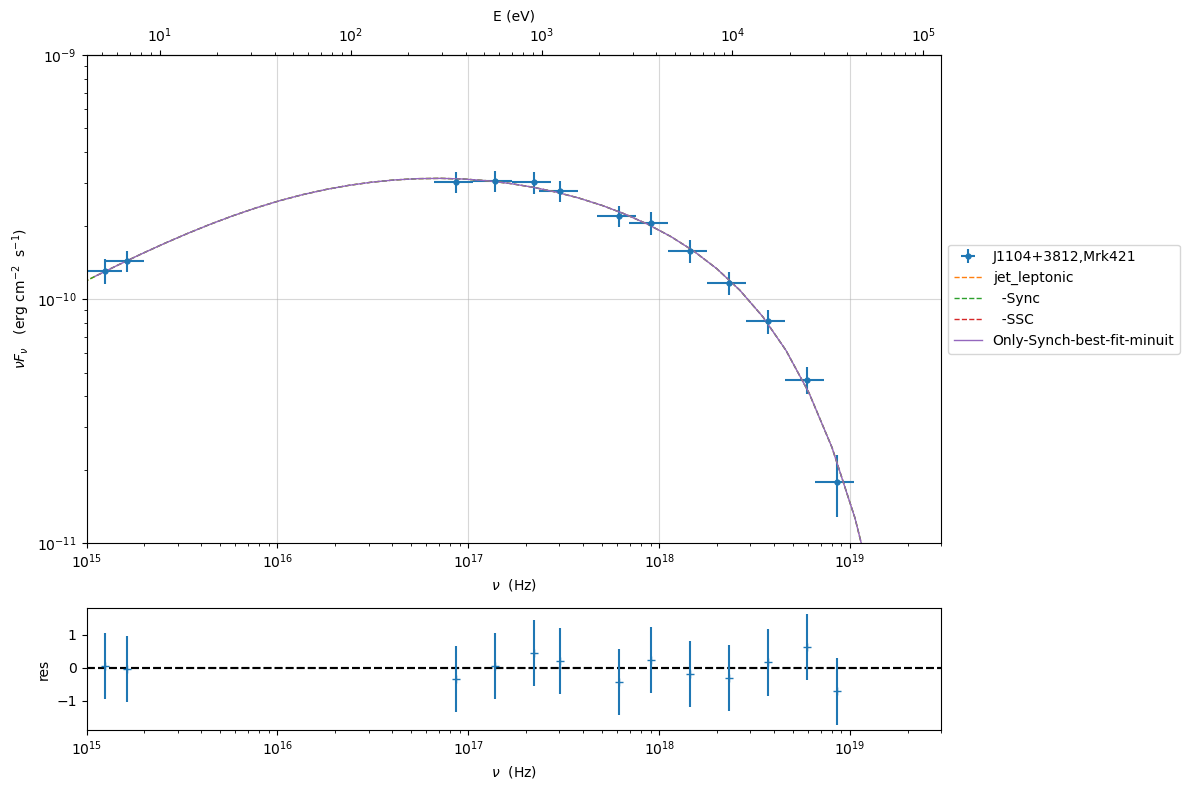

In [16]:
%matplotlib inline
fit_model_minuit.set_nu_grid(1E6,1E30,200)
fit_model_minuit.eval()
p2=fit_model_minuit.plot_model(sed_data=sed_data)
p2.setlim(y_min=1E-11,x_min=1E15,y_max=1E-9,x_max=3E19)

In [17]:
try:
    c=model_minimizer_minuit.minimizer.draw_contour('r','s')
except:
    pass

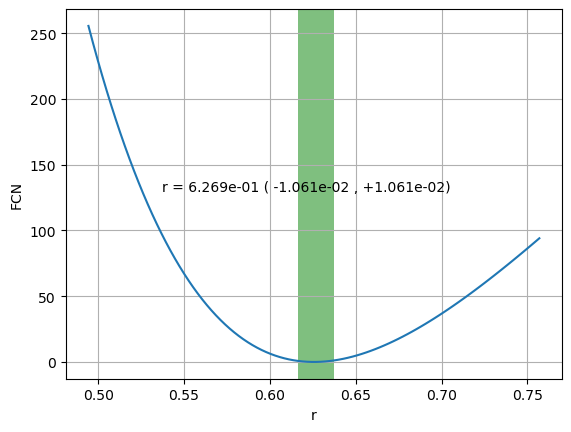

In [18]:
m=model_minimizer_minuit.minimizer.draw_profile('r')

In [19]:
best_fit_minuit.save_report('SSC-best-fit-minuit.pkl')
model_minimizer_minuit.save_model('model_minimizer_minuit.pkl')
fit_model_minuit.save_model('fit_model_minuit.pkl')

## MCMC sampling

### creating and setting the sampler

In [20]:
from jetset.mcmc import McmcSampler
from jetset.minimizer import ModelMinimizer


In [21]:
model_minimizer_minuit = ModelMinimizer.load_model('model_minimizer_minuit.pkl')
mcmc=McmcSampler(model_minimizer_minuit)

===> setting C threads to 12


In [22]:
labels=['N','B','beam_obj','s','gamma0_log_parab']
model_name='jet_leptonic'
use_labels_dict={model_name:labels}

mcmc.set_labels(use_labels_dict=use_labels_dict)

In [23]:
mcmc.set_bounds(bound=5.0,bound_rel=True)

par: N  best fit value:  1.08364419186145  mcmc bounds: [0, 6.501865151168699]
par: B  best fit value:  0.014223870997614777  mcmc bounds: [0, 0.08534322598568866]
par: beam_obj  best fit value:  36.271677271204155  mcmc bounds: [5.0, 50.0]
par: s  best fit value:  2.1213601289476283  mcmc bounds: [-8.485440515790513, 10]
par: gamma0_log_parab  best fit value:  40475.33090501091  mcmc bounds: [1, 242851.98543006548]


In [24]:
mcmc.run_sampler(nwalkers=20, burnin=50,steps=500,progress='notebook')

===> setting C threads to 12
mcmc run starting



  0%|          | 0/500 [00:00<?, ?it/s]

mcmc run done, with 1 threads took 313.02 seconds


In [25]:
print(mcmc.acceptance_fraction)

0.3696


### plotting the model

To plot the sampled model range against the input best-fit model

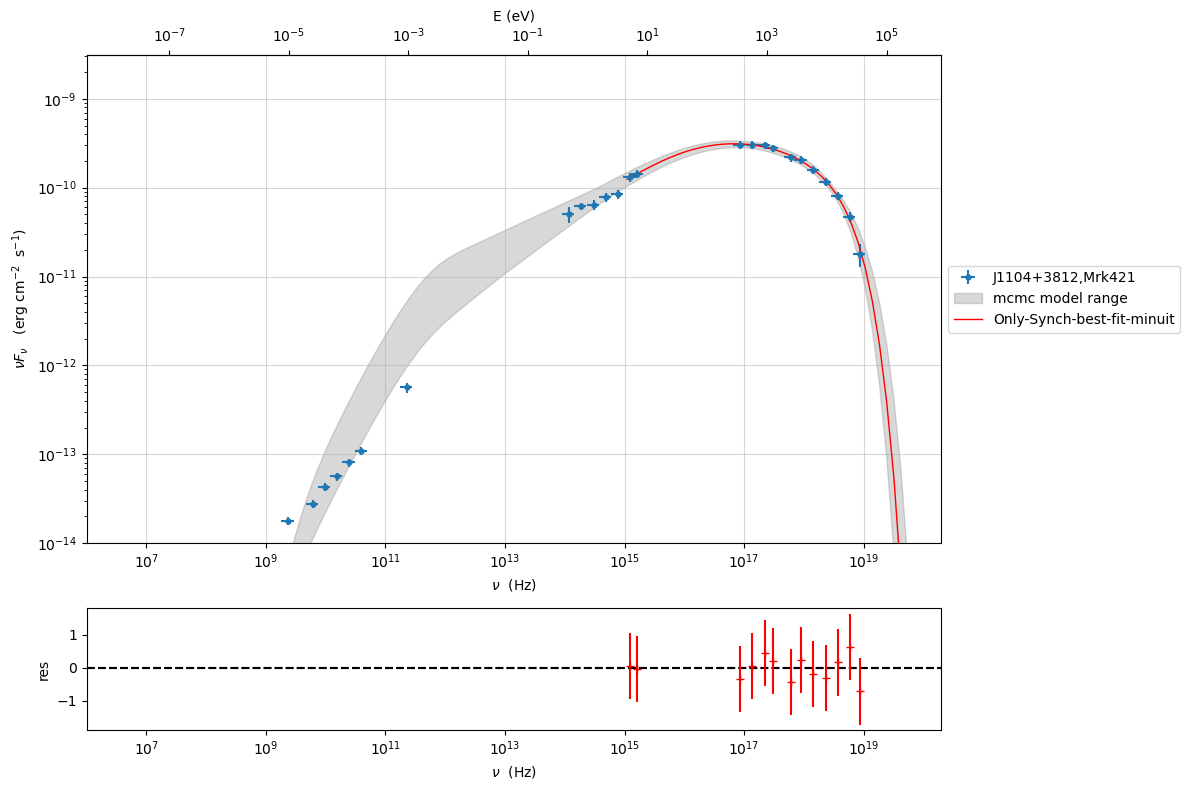

In [26]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E15, 1E20],size=100)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E20)

To plot the sampled model range,providing quantiles, against the input best-fit model, providing quantiles

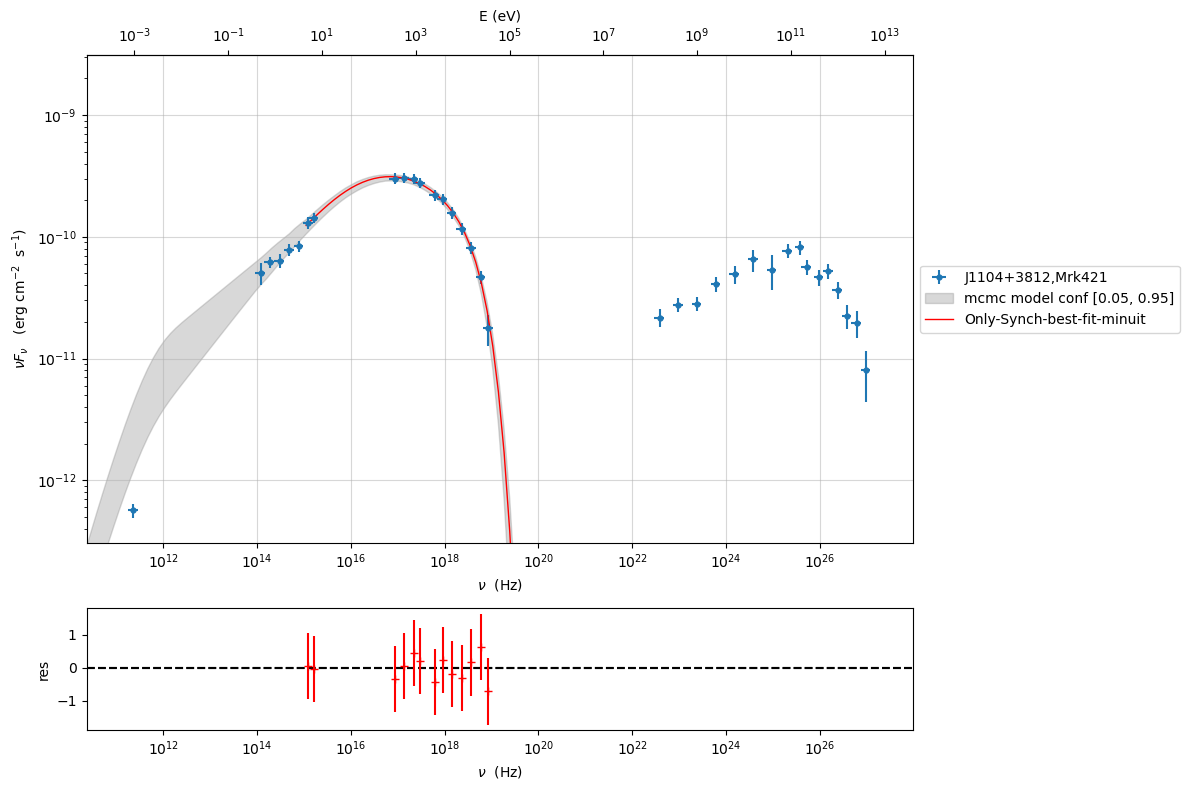

In [27]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E15, 1E20],size=100,quantiles=[0.05,0.95])

To plot the sampled model range,providing quantiles, against the input mcmc model at 0.5 quantile (``plot_mcmc_best_fit_model==True`` provides the 0.5 quantile sampled model)

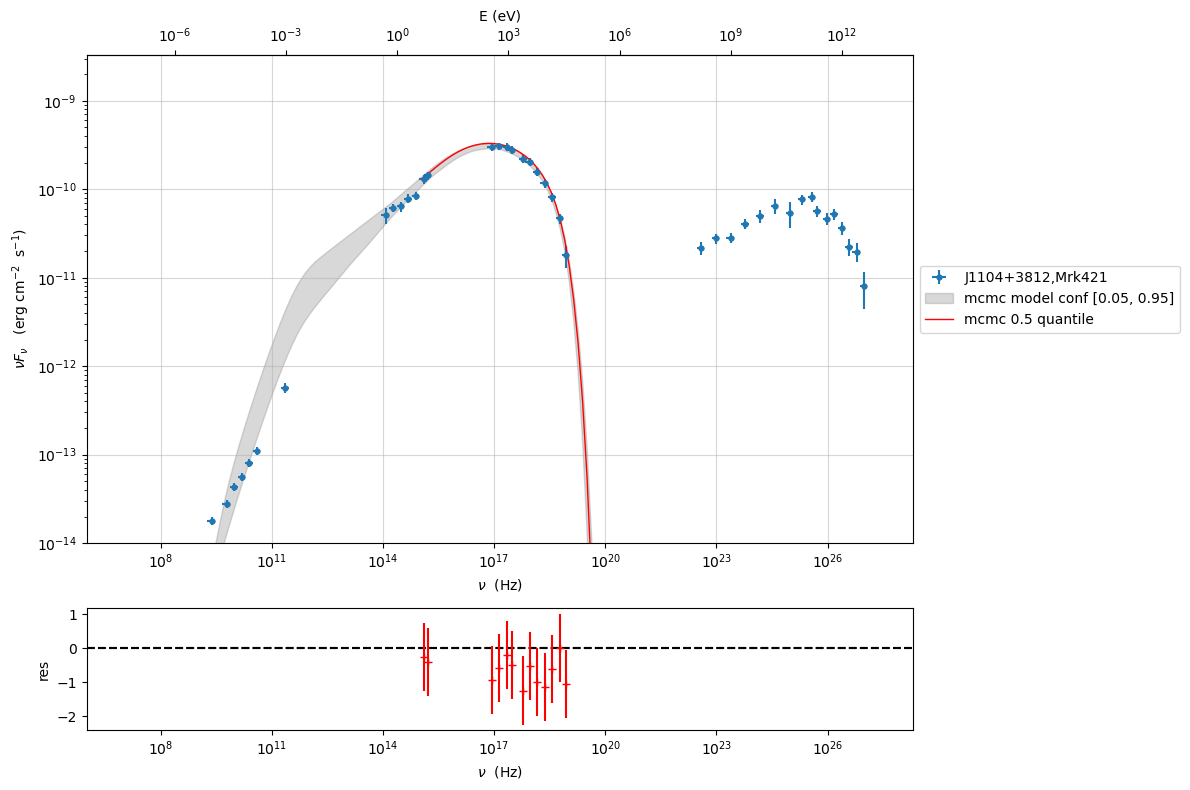

In [28]:
p=mcmc.plot_model(sed_data=sed_data,fit_range=[1E15, 1E20],size=100,quantiles=[0.05,0.95], plot_mcmc_best_fit_model=True)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E28)

In [29]:
mcmc.labels

['N', 'B', 'beam_obj', 's', 'gamma0_log_parab']

To have a better rendering on the scatter plot, we redefine the plot labels

In [30]:
mcmc.set_plot_label('N',r'$N$')
mcmc.set_plot_label('B',r'$B$')
mcmc.set_plot_label('beam_obj',r'$\delta$')
mcmc.set_plot_label('s',r'$s$')
mcmc.set_plot_label('gamma0_log_parab',r'$\gamma_0$')

the code below lets you tuning the output

1) mpl.rcParams['figure.dpi'] if you increase it you get a better definition
2) title_fmt=".2E" this is the format for python, 2 significant digits, scientific notation
3) title_kwargs=dict(fontsize=12) you can change the fontsizef=mcmc.plot_chain('s',log_plot=False)

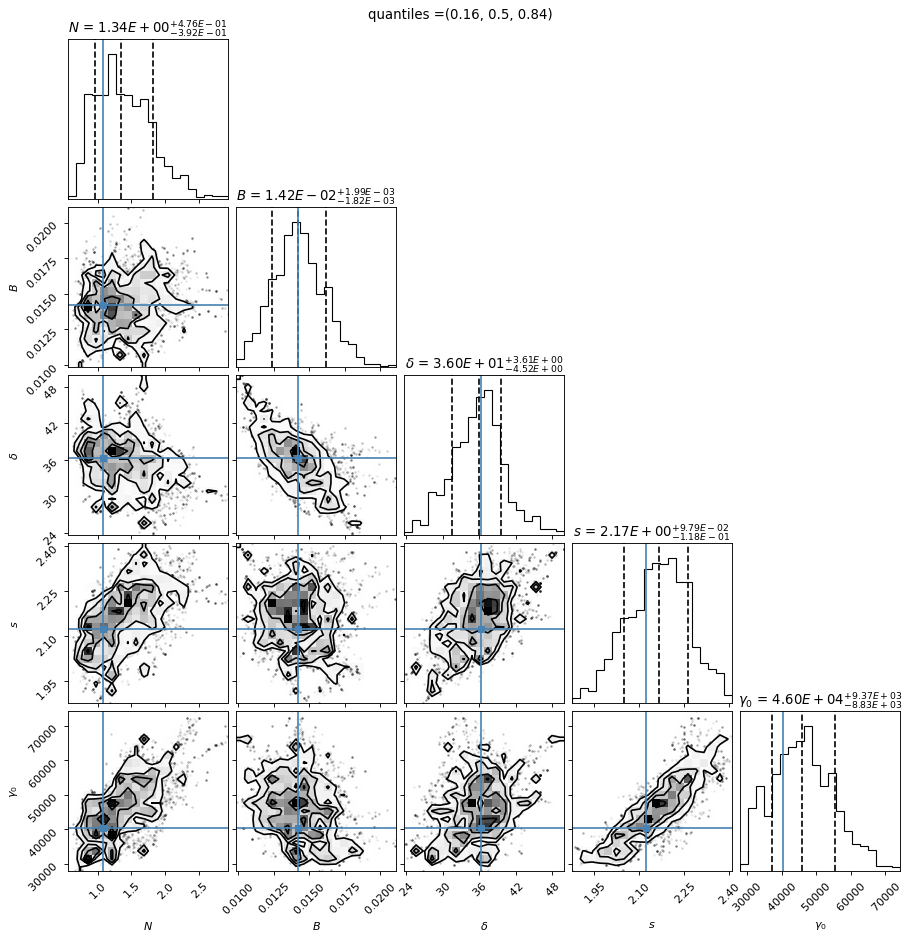

In [31]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 80
f=mcmc.corner_plot(quantiles=(0.16, 0.5, 0.84),title_kwargs=dict(fontsize=12),title_fmt=".2E",use_math_text=True)

In [32]:
mcmc.get_par('N')

(array([0.98484506, 1.09568988, 0.9554807 , ..., 1.82525111, 1.70817598,
        1.66367392]),
 0)

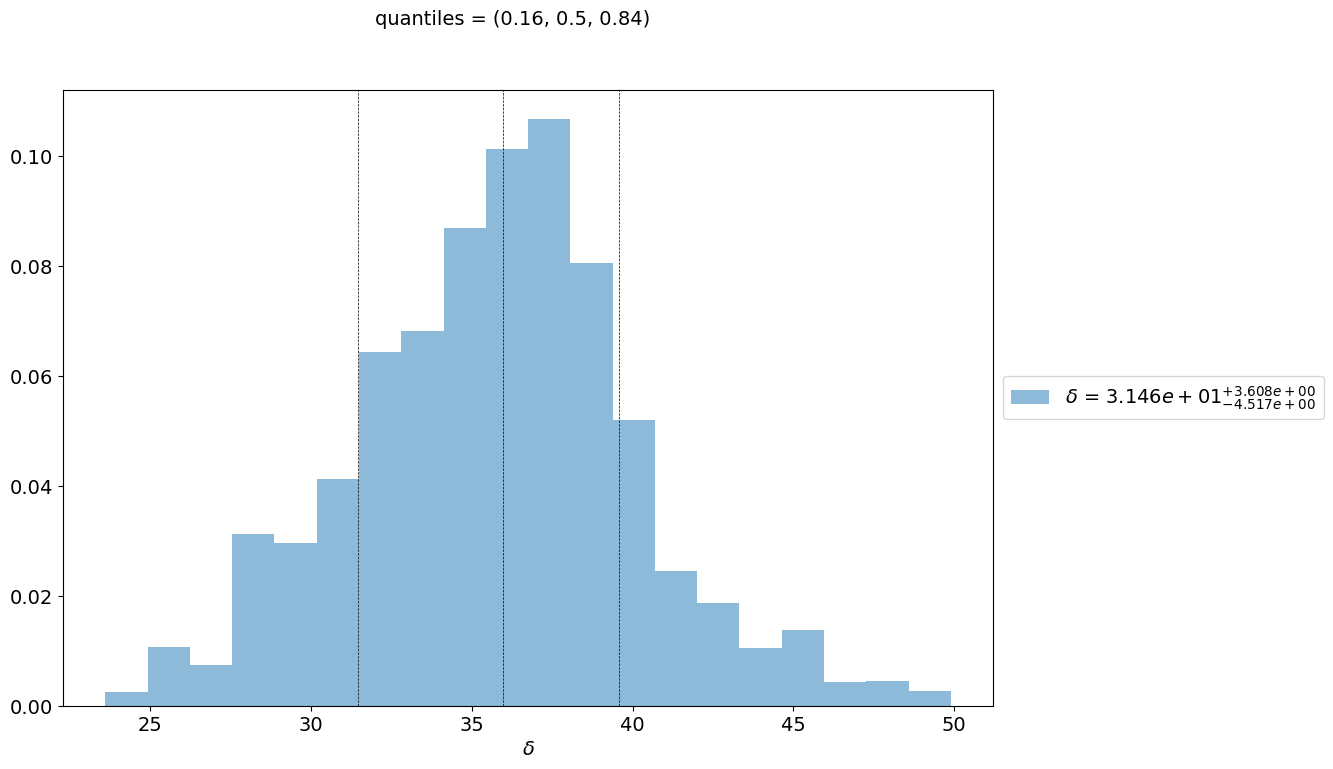

In [33]:
f=mcmc.plot_par('beam_obj')

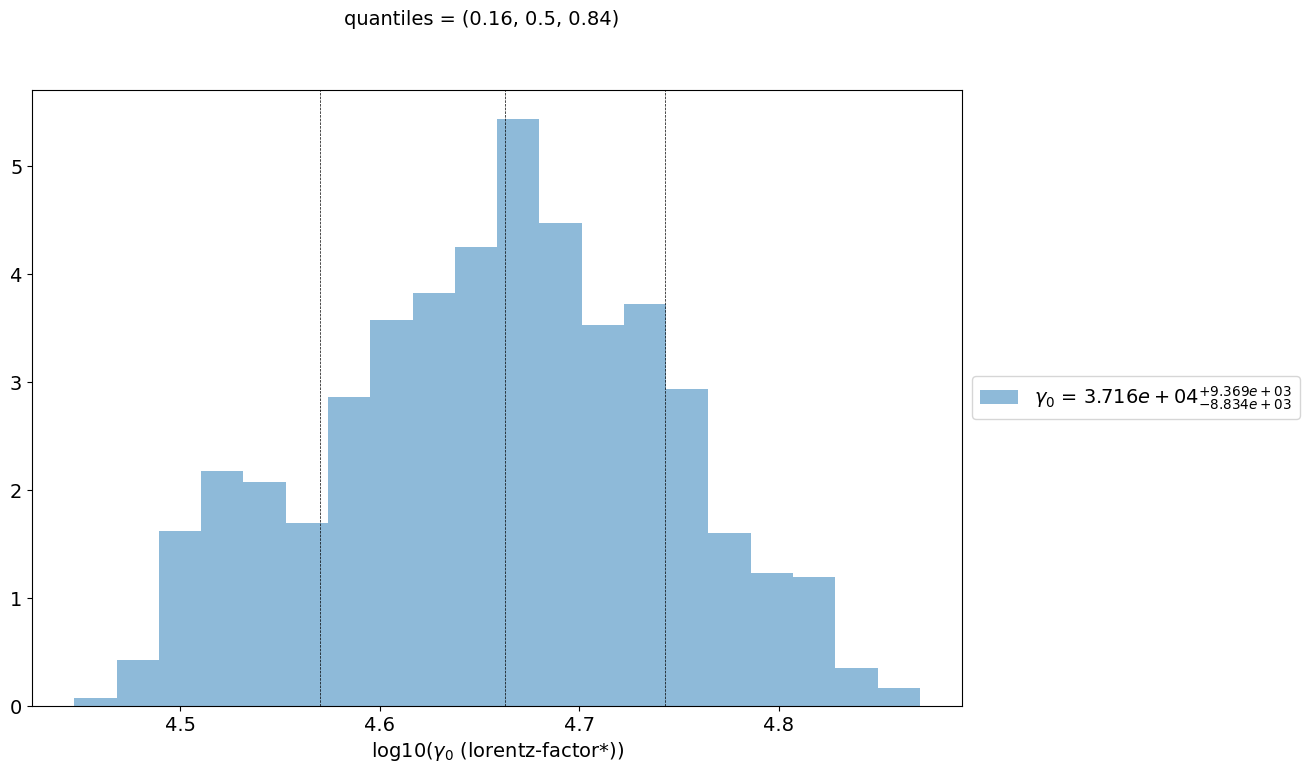

In [34]:
f=mcmc.plot_par('gamma0_log_parab',log_plot=True)

## Save and reuse MCMC

In [35]:
mcmc.save('mcmc_sampler.pkl')

In [36]:
from jetset.mcmc import McmcSampler
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.test_data_helper import  test_SEDs

sed_data=ObsData.load('Mrk_401.pkl')

ms=McmcSampler.load('mcmc_sampler.pkl')

===> setting C threads to 12
===> setting C threads to 12


In [37]:
ms.model.name

'Only-Synch-best-fit-minuit'

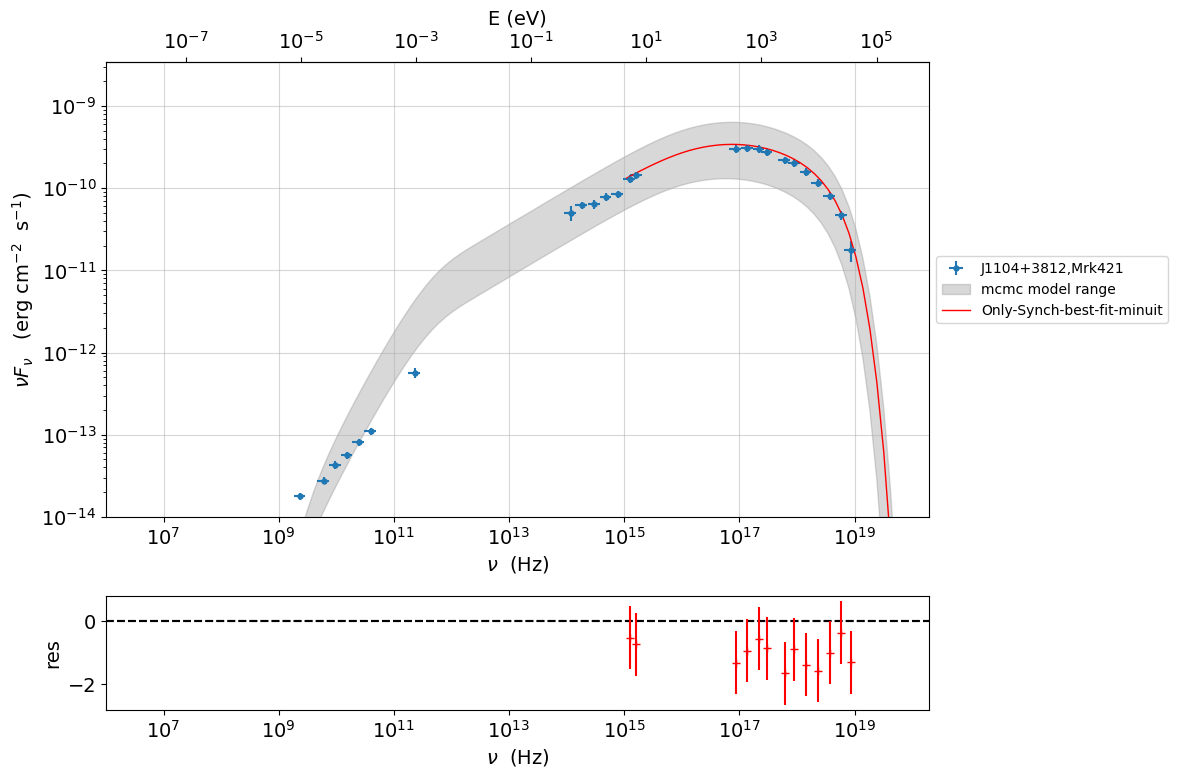

In [38]:
p=ms.plot_model(sed_data=sed_data,fit_range=[1E15, 1E20],size=50)
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E20)

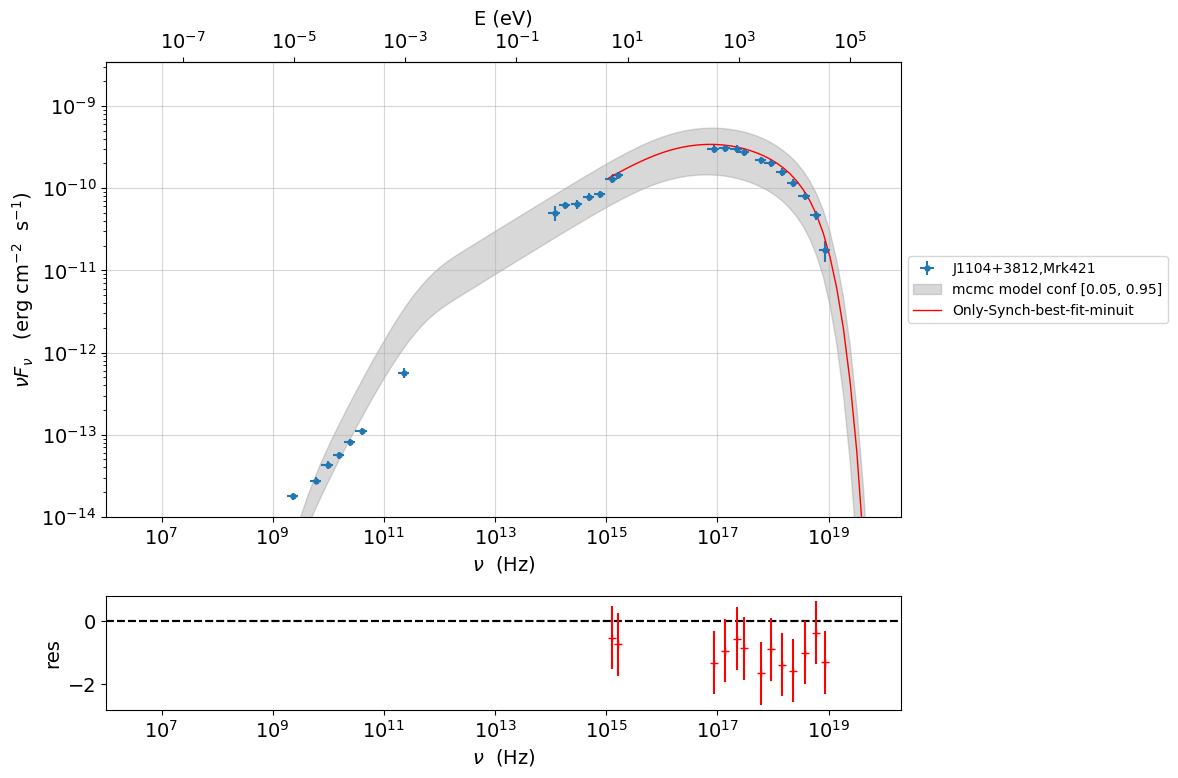

In [39]:
p=ms.plot_model(sed_data=sed_data,fit_range=[1E15, 1E20],size=100,quantiles=[0.05,0.95])
p.setlim(y_min=1E-14,x_min=1E6,x_max=2E20)

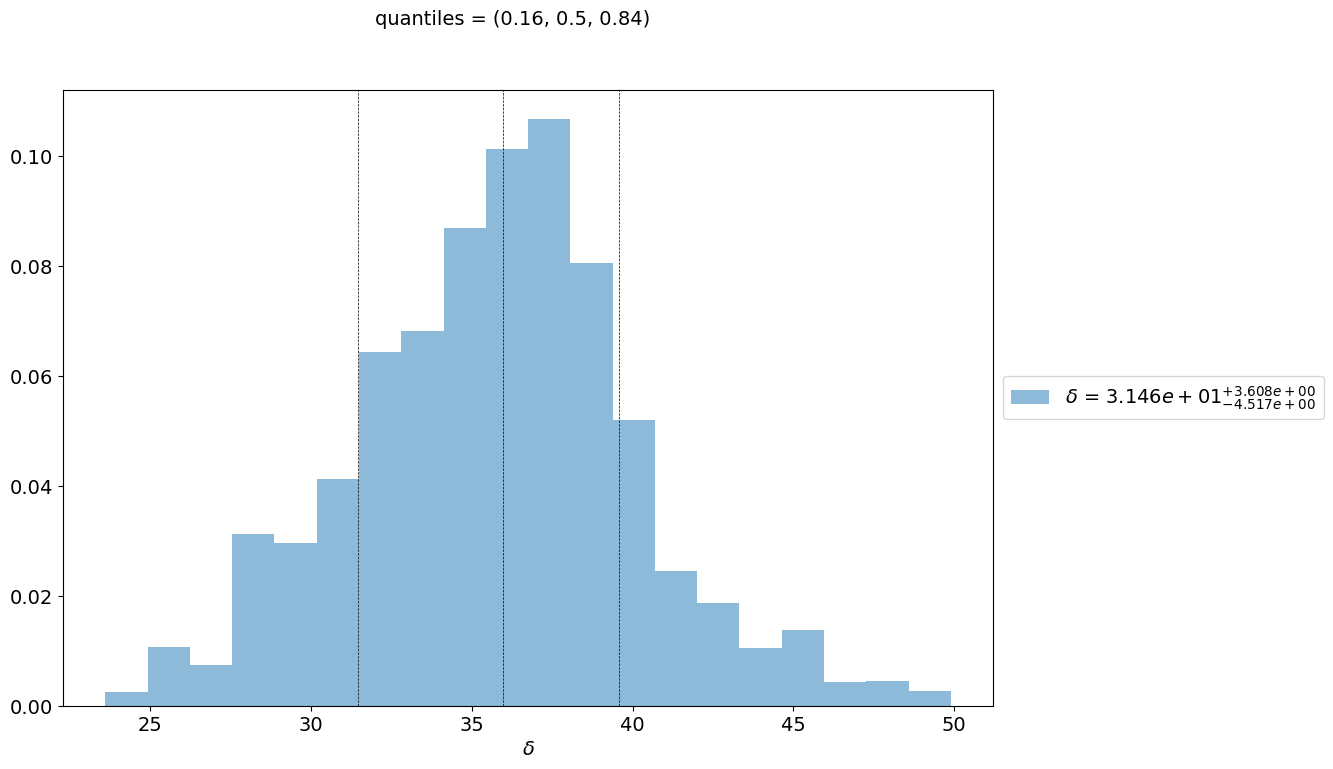

In [40]:
f=ms.plot_par('beam_obj',log_plot=False)


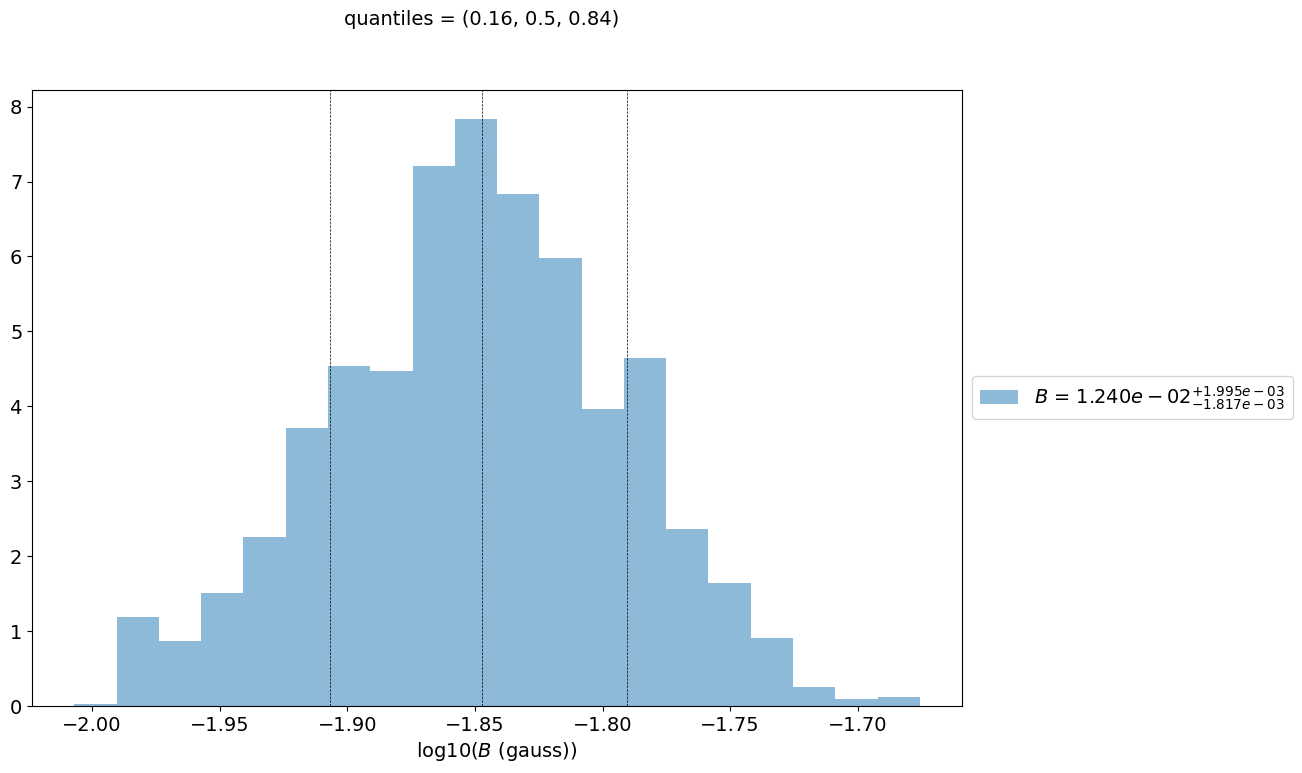

In [41]:
f=ms.plot_par('B',log_plot=True)


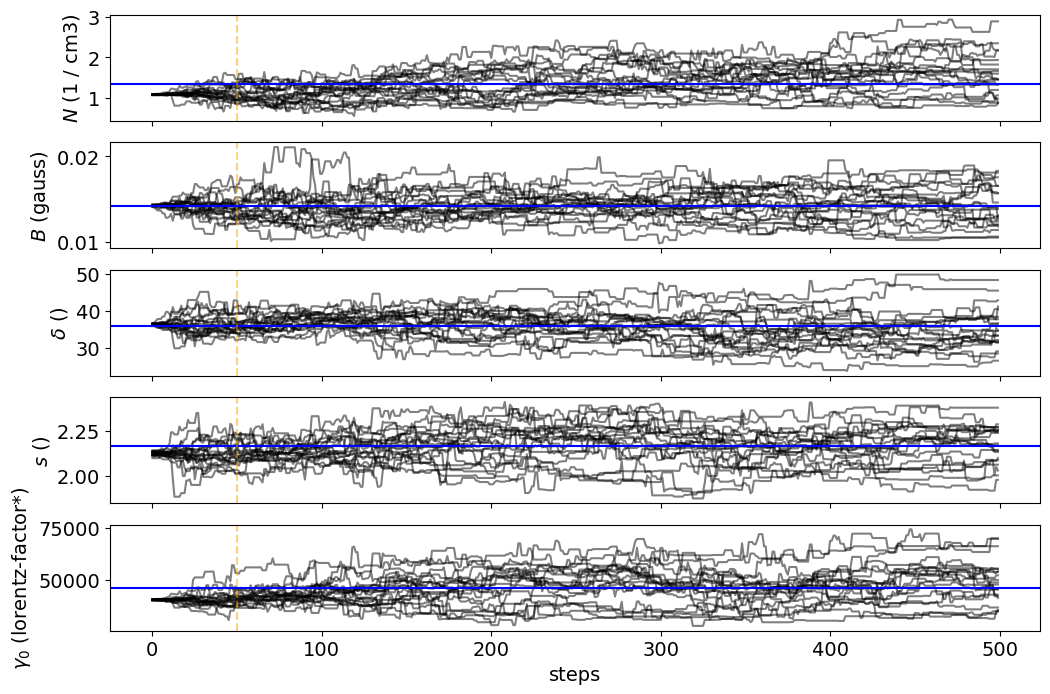

In [42]:
f=mcmc.plot_chain(log_plot=False)

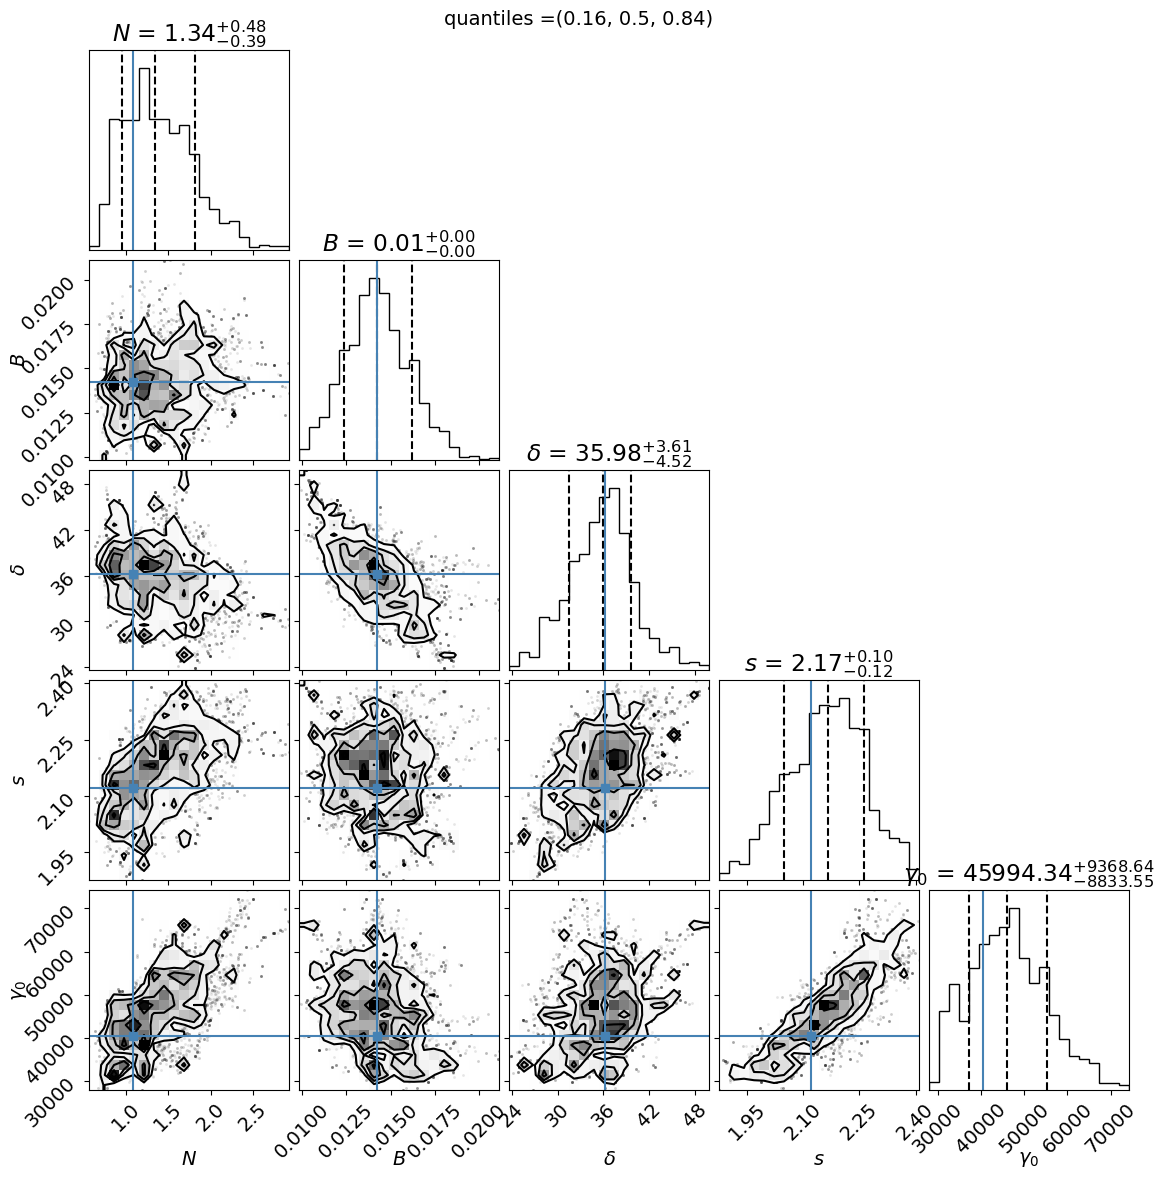

In [43]:
f=mcmc.corner_plot()